Construct MRI data pipeline that pre-process and augment brain images; train a Vision Transformer, ViT -based classification model on labeled images with and without brain tumors; use trained model for inference and plot a confusion matrix.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/ColabNotebooks/ExplainableAI

/content/drive/MyDrive/ColabNotebooks/ExplainableAI


# Training of Vision Transformer for Brain Tumor Classification

In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import glob
import pandas as pd
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


## Load and split MRI dataset

### Set dataset paths

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

In [ ]:
train_normal_fp = "mri_data_full/train/notumor/"
train_tumor_fp = "mri_data_full/train/tumor/"

test_normal_fp = "mri_data_full/test/notumor/" # use for validation
test_tumor_fp  = "mri_data_full/test/tumor/"   # use for validation

### Split datasets

In [ ]:
# use the data paths to create training, test and validation datasets of normal and tumor images
train_normal_labels = ["normal"] * len(glob.glob(train_normal_fp + '*.jpg'))
train_tumor_labels = ["tumor"] * len(glob.glob(train_tumor_fp + '*.jpg'))
train_imgs = glob.glob(train_normal_fp + '*.jpg') + glob.glob(train_tumor_fp + '*.jpg')
train_labels = train_normal_labels + train_tumor_labels
# data frame to store file paths and coresponding labels
train_data = pd.DataFrame(list(zip(train_imgs, train_labels)), columns = ['file_path', 'label'])
# add int_label column 0 for "normal", 1 for "tumor" containing images
train_data['int_label'] = train_data['label'].map({'normal': 0, 'tumor': 1})
print(f"Training and test datasets image count: {len(train_data)}")
# split data frame into training and testing
train = train_data.sample(frac=0.8,random_state=123)
test = train_data.drop(train.index)

# convert pandas DataFrame to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

val_normal_labels = [0] * len(glob.glob(test_normal_fp + '*.jpg'))
val_tumor_labels = [1] * len(glob.glob(test_tumor_fp + '*.jpg'))
val_imgs = glob.glob(test_normal_fp + '*.jpg') + glob.glob(test_tumor_fp + '*.jpg')
val_labels = val_normal_labels + val_tumor_labels
val = pd.DataFrame(list(zip(val_imgs, val_labels)), columns = ['file_path', 'label'])
val['int_label'] = val['label'].map({'normal': 0, 'tumor': 1})
print(f"Validation dataset image count: {len(val)}")
val_dataset = Dataset.from_pandas(val)

# create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'val': val_dataset
})

# access the datasets
train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['val']



Training and test datasets image count: 2934
Validation dataset image count: 711


In [ ]:
train_dataset.to_pandas().head()

,file_path,label,int_label,__index_level_0__
0,mri_data_full/train/tumor/Tr-me_0482.jpg,tumor,1,2861
1,mri_data_full/train/notumor/Tr-no_0137.jpg,normal,0,1289
2,mri_data_full/train/notumor/Tr-no_0980.jpg,normal,0,208
3,mri_data_full/train/tumor/Tr-me_1278.jpg,tumor,1,2549
4,mri_data_full/train/notumor/Tr-no_1350.jpg,normal,0,994


### Display random image from training and test sets

Image path: mri_data_full/train/notumor/Tr-no_0070.jpg
Image path: mri_data_full/train/notumor/Tr-no_1484.jpg


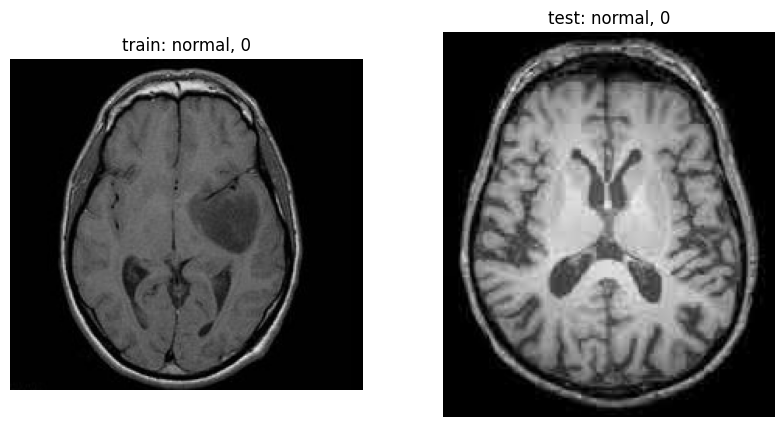

In [ ]:
def display_random_image(data, ds_name, ax=None):
  """Function that displays a random image from the dataset on the specified axes."""

  random_index = random.randint(0, len(data) - 1)

  img_path = data['file_path'][random_index]
  img_label = data['label'][random_index]
  img_int_label = data['int_label'][random_index]

  # print image path
  print(f"Image path: {img_path}")
  #print(f"Image label: {img_label}")
  #print(f"Image int label: {img_int_label}")

  img = cv2.imread(img_path)

  # use ax if provided, otherwise use plt
  if ax is not None:
    ax.axis('off')  # remove axes and ticks
    ax.set_title(f"{ds_name}: {img_label}, {img_int_label}")
    ax.imshow(img)
  else:
    plt.axis('off')
    plt.title(f"{ds_name}: {img_label}, {img_int_label}")
    plt.imshow(img)
    plt.show()

# create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display random images on each subplot
display_random_image(train_dataset, "train", ax=axs[0])
display_random_image(test_dataset, "test", ax=axs[1])

# show the figure with both images
plt.show()

In [ ]:
# get pixel size of random image in 2D, i.e. GRAYSCALE img
img = cv2.imread(train_data['file_path'][random.randint(0, len(train_data) - 1)], cv2.IMREAD_GRAYSCALE)
print(f"Random image of data type {type(img).__name__} and size: {img.shape}")

Random image of data type ndarray and size: (512, 512)


## Set up ViT image processor

Use python transformers library from Hugging Face

### Data normalization

Vit models are trained with specific transformations applied to images fed into them. To make sure the correct transformation is used display the ViTImageProcessor. initialized with a configuration that was saved alon with the prtrained model.

In [ ]:
import torch
from transformers import ViTImageProcessor


model_name_or_path = 'google/vit-base-patch16-224'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

processor = ViTImageProcessor.from_pretrained(model_name_or_path)
print(f"Image processor configuration:\n {processor}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Image processor configuration:
 ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



To process an image, pass it to the image processor's call function. This will return a dict containing pixel values, which is the numeric representation to be passed to the model.

In [ ]:
img = cv2.imread(train_data['file_path'][random.randint(0, len(train_data) - 1)])  # cv2.IMREAD_GRAYSCALE

# for the processor to return torch tensors set return_tensors="pt", defaut numpy arrays
processor(img, return_tensors="pt")
print(f"The shape of the image tensor: {processor(img, return_tensors='pt')['pixel_values'].shape}")

The shape of the image tensor: torch.Size([1, 3, 224, 224])


### Process the Dataset

In [ ]:
def process_example(example):
  """ Read an image and transform it into inputs. """
  image = cv2.imread(example['file_path'])
  inputs = processor(image, return_tensors='pt')
  inputs['labels'] = example['label']
  return inputs

In [ ]:
process_example(dataset['train'][0])

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]]), 'labels': 'tumor'}

Transform the dataset while indexing every example in a batch

In [ ]:
def transform(batch):
    """
    Processes a batch of images, converting them to pixel values and
    adding labels to the output dictionary.
    """
    # Get the list of image file paths from the batch
    image_paths = batch['file_path']

    # Read and preprocess each image
    images = [cv2.imread(image_path) for image_path in image_paths]
    inputs = processor(images=images, return_tensors='pt')

    # Add the labels to the output
    inputs['labels'] = batch['int_label']
    return inputs

In [ ]:
prepared_dataset = dataset.with_transform(transform)

In [ ]:
prepared_dataset['train'][0:2]

{'pixel_values': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1

In [ ]:
# access the image data directly by accessing the 'pixel_values' key from the
# preprocessed output stored in the 'prepared_dataset' for selected items
print(f"The shape of the pixel values tensor: {prepared_dataset['train'][0:2]['pixel_values'].shape}")

The shape of the pixel values tensor: torch.Size([2, 3, 224, 224])


In [ ]:
# pixel values of and random image should be normalized between -1 and 1
print(f"The min value of the pixel values tensor: {prepared_dataset['train'][3]['pixel_values'].min()}")
print(f"The max value of the pixel values tensor: {prepared_dataset['train'][3]['pixel_values'].max()}")


The min value of the pixel values tensor: -1.0
The max value of the pixel values tensor: 0.8274509906768799


### Data Augmentation

In [ ]:
def random_transform(image, rot_angle=45, scale_min=0.7, scale_max=1.2):
    """Applies random flip, rotation, zoom, and scaling to an image."""

    # Random horizontal flipping
    if random.random() < 0.5:
        image = cv2.flip(image, 1)

    # Random rotation
    angle = random.randint(-rot_angle, rot_angle)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))

    # Random scaling
    scale_factor = random.uniform(scale_min, scale_max)
    image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)

    # Random zoom (by cropping and resizing)
    if random.random() < 0.5:
        # Define zoom factors (adjust as needed)
        zoom_factor_x = random.uniform(1, 1.5)  # Zoom in by up to 50%
        zoom_factor_y = random.uniform(1, 1.5)

        # Calculate new dimensions for cropping
        new_width = int(image.shape[1] / zoom_factor_x)
        new_height = int(image.shape[0] / zoom_factor_y)

        # Calculate starting point for cropping
        x_start = random.randint(0, image.shape[1] - new_width)
        y_start = random.randint(0, image.shape[0] - new_height)

        # Crop the image
        cropped_image = image[y_start:y_start + new_height, x_start:x_start + new_width]

        # Resize back to original dimensions
        image = cv2.resize(cropped_image, (image.shape[1], image.shape[0]))

    return image

def transform(batch):
    """
    Processes a batch of images, converting them to pixel values,
    adding labels, and applying augmentations.
    """
    image_paths = batch['file_path']
    images = [cv2.imread(image_path) for image_path in image_paths]

    # Apply augmentations before preprocessing
    augmented_images = [random_transform(img) for img in images]

    inputs = processor(images=augmented_images, return_tensors='pt')
    inputs['labels'] = batch['int_label']
    return inputs

# normalize and augment training data set
augmented_dataset = dataset.with_transform(transform)

# display pixel_values and label for two augmented images
augmented_dataset['train'][0:2]

{'pixel_values': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1

## Classification-accuracy metric

**Accuracy** is the simplest way to measure performance

In [ ]:
def accuracy_score(predictions, labels):
  """ A function that calculates the accuracy of the model's predictions by
      taking in a list or numpy arr of predicted labels and labels as a list or
      numpy array of true labels."""

  correct = np.sum(predictions == labels)  # Count correct predictions
  total = len(labels)  # Total number of samples

  return correct/total

**Confusion matrix** which describes the model performance fromm different angles: <br><br>

|        | Predicted Tumor | Predicted Normal |
| :----- | :-------------: | ---------------: |
| Tumor  |       TP        |       FN         |
| Normal |       FP        |       TN         |

**Recall**, aka **Sensitivity** is how images withtumor were incorrectlydiagnosed <br>
<p align="center">
$Recall$ = $\frac{TP}{TP + FN}$ <br><br>
</p>

**Precision**, aka **Specificity** is how many of the normal images were diagnosed as tumor <br>
<p align="center">
$Precosion$ = $\frac{TP}{TP + FP}$ <br><br>
</p>

**F-score** summarizes the performance of a classifier with a single metric as a *harmonic mean* of recall $r$ and precision $p$: <br>
<p align="center">
$F-score$ = $\frac{2pr}{p + r}$
</p>


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

## Train ViT classification model

ViT model consists of a BERT-like encoder and a linear classification head on top of the last hidden state of the Classification token. Each image is split into a sequence of non-overlapping patches (of resolutions like 16x16 or 32x32), which are linearly embedded, absolute position embeddings are added, and sent through a stack of encoder layers. A classification token is added at the beginning in order to get a representation of the entire image. A linear classification head can be added on top of the final hidden state in order to classify images.



### Instnatiate pre-trained ViT classification model

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    attn_implementation="sdpa",
    torch_dtype=torch.float16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### Set up optimizer and a learning rate schedule

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5)

# calculate num_training_steps based on the data
batch_size = 32
num_epochs = 20
num_training_steps = len(augmented_dataset['train']) // batch_size * num_epochs


scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
len(augmented_dataset['train']) // batch_size * num_epochs

730

### Forward pass the training data

### TensorBoard callbacks

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# create a TensorBoard SummaryWriter
writer = SummaryWriter()

### Run training

In [ ]:
from torch.utils.data import DataLoader

# Assuming train_dataset is your training dataset
train_loader = DataLoader(augmented_dataset['train'], batch_size=32, shuffle=True)

for epoch in range(num_epochs):
  # Initialize lists to store predictions and labels for the epoch
    all_predictions = []
    all_labels = []
    print(f"======================= Epoch: {epoch + 1} ========================")
    print()

    #for batch in train_loader:
    for batch_index, batch in enumerate(train_loader):
        # access the preprocessed pixel values
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=inputs, labels=labels)
        loss = outputs.loss
        # print out the loss
        print(f"Batch number: {batch_index} Loss: {loss.item()}")
        # backpropagate the loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # get predictions for the batch
        _, preds = torch.max(outputs.logits, 1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # calculate metrics for the epoch
    #accuracy = accuracy_score(np.array(all_predictions), np.array(all_labels))
    accuracy = accuracy_score(all_predictions, all_labels) # accuracy_score from sklean.metrics
    recall = recall_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # log metrics to TensorBoard (if using)
    writer.add_scalar('Accuracy/train', accuracy, epoch)
    writer.add_scalar('Recall/train', recall, epoch)
    writer.add_scalar('Precision/train', precision, epoch)
    writer.add_scalar('F1/train', f1, epoch)

    # Print or log the metrics as needed
    print()
    print(f"Epoch {epoch + 1}: Accuracy={accuracy:.4f}, Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}")
    print()

======================= Epoch: 1 ========================

Batch number: 0 Loss: 0.22021484375
Batch number: 1 Loss: 0.187744140625
Batch number: 2 Loss: 0.35009765625
Batch number: 3 Loss: 0.28076171875
Batch number: 4 Loss: 0.185791015625
Batch number: 5 Loss: 0.266845703125
Batch number: 6 Loss: 0.42724609375
Batch number: 7 Loss: 0.1658935546875
Batch number: 8 Loss: 0.454833984375
Batch number: 9 Loss: 0.1846923828125
Batch number: 10 Loss: 0.421142578125
Batch number: 11 Loss: 0.384033203125
Batch number: 12 Loss: 0.230712890625
Batch number: 13 Loss: 0.2371826171875
Batch number: 14 Loss: 0.234375
Batch number: 15 Loss: 0.263916015625
Batch number: 16 Loss: 0.43310546875
Batch number: 17 Loss: 0.202880859375
Batch number: 18 Loss: 0.2176513671875
Batch number: 19 Loss: 0.1317138671875
Batch number: 20 Loss: 0.1988525390625
Batch number: 21 Loss: 0.251220703125
Batch number: 22 Loss: 0.385498046875
Batch number: 23 Loss: 0.2425537109375
Batch number: 24 Loss: 0.1719970703125
Batc

In [ ]:
# after ot during training loop start TensorBoard to view logged data
%load_ext tensorboard
%tensorboard --logdir runs

### Run the model on test data

The model is set to evaluation mode with model.eval(). The code iterates through the test_loader, gets the model's predictions, and stores them along with the true labels.

In [ ]:
# create the test data loader
test_loader = DataLoader(augmented_dataset['test'], batch_size=32, shuffle=False)

# run inference on the test data
all_predictions = []
all_labels = []
# set the model to evaluation mode
model.eval()
# disable gradient calculation during inference
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=inputs, labels=labels)
        _, preds = torch.max(outputs.logits, 1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# calculate and print evaluation metrics
accuracy = accuracy(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test F1 Score: {f1:.4f}")


## Display images with predicted and labeled ids

In [ ]:
import seaborn as sns

# select 9 images from the validation dataset
val_subset = augmented_dataset['val'][:9]

# create a DataLoader for the subset
val_loader = DataLoader(val_subset, batch_size=9, shuffle=False)

# run inference and store predictions and true labels
all_predictions = []
all_labels = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during inference
    for batch in val_loader:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=inputs, labels=labels)
        _, preds = torch.max(outputs.logits, 1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Display images with true and predicted labels
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.ravel()  # Flatten the axes array

for i, (image_data, true_label, predicted_label) in enumerate(zip(val_subset, all_labels, all_predictions)):
    image = cv2.imread(image_data['file_path'])
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f"True: {true_label}, Predicted: {predicted_label}")

plt.tight_layout()
plt.show()

# Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()